In [845]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:

import os
import json

# Data Wrangling
import h5py
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


In [531]:
df = pd.read_csv('D:\ZebrafishMatlabCSV\CatchAllBouts_atlas_20200525_1551_df.csv')

In [532]:
df.head(10)

,Unnamed: 0,x_blob,y_blob,x_mideye,y_mideye,body_angle,tail_active,bout_cat_matlab,bout_sign_matlab,tail_angle_01,tail_angle_02,tail_angle_03,tail_angle_04,tail_angle_05,tail_angle_06,tail_angle_07,tail_angle_08,tail_angle_09,tail_angle_10
0,0,-22.776156,4.353595,-22.979468,3.989994,-2.218813,0.0,0.0,0.0,-0.101865,0.009052,-0.014832,-0.002931,0.062876,-0.098187,0.015472,0.071523,-0.069813,-100.0
1,1,-22.772089,4.360613,-22.977063,3.998453,-2.225990,0.0,0.0,0.0,-0.082618,-0.005339,-0.008994,0.004492,-0.026959,0.076065,-0.056434,-0.001953,-0.069813,-100.0
2,2,-22.774215,4.356021,-22.978636,3.993386,-2.221900,0.0,0.0,0.0,-0.093377,-0.001858,0.000944,-0.011644,0.032151,-0.010409,-0.060185,0.031980,0.069813,-100.0
3,3,-22.776261,4.354568,-22.981788,3.992900,-2.223969,0.0,0.0,0.0,-0.092590,0.008940,-0.017288,0.012715,-0.009147,-0.002189,-0.001979,0.010266,0.069813,-100.0
4,4,-22.772210,4.362054,-22.977184,3.999899,-2.226333,0.0,0.0,0.0,-0.086849,0.004867,-0.014723,-0.021769,0.072211,-0.090195,0.021047,0.030112,0.069813,-100.0
5,5,-22.778177,4.360967,-22.983703,3.999293,-2.231143,0.0,0.0,0.0,-0.087602,0.015071,-0.021669,0.000230,0.050095,-0.097736,0.079296,-0.006926,-0.069813,-100.0
6,6,-22.781719,4.357167,-22.987245,3.995493,-2.229710,0.0,0.0,0.0,-0.095926,0.020833,-0.012953,-0.029609,0.080419,-0.093356,0.018150,0.023856,0.069813,-100.0
7,7,-22.785750,4.351044,-22.991827,3.989850,-2.229120,0.0,0.0,0.0,-0.102548,0.037784,-0.032879,0.018202,-0.029834,0.046422,-0.052006,0.009501,0.069813,-100.0
8,8,-22.775696,4.359839,-22.982874,3.999617,-2.231915,0.0,0.0,0.0,-0.085197,0.012922,-0.013468,-0.030067,0.088528,-0.112809,0.056817,0.014401,-0.008511,-100.0
9,9,-22.774629,4.360169,-22.980156,3.998495,-2.227599,0.0,0.0,0.0,-0.095254,0.027007,-0.029976,-0.008196,0.072450,-0.121947,0.080021,0.001531,-0.010563,-100.0


In [533]:
from utils import smallestenclosingcircle

def compute_outer_circle(x,y,interval=100):
    p= [(x[i],y[i]) for i in np.arange(0,len(x),interval)]
    Circle = smallestenclosingcircle.make_circle(p)
    xc=Circle[0]
    yc=Circle[1]
    radius=Circle[2]
    return (xc,yc,radius)    
            

In [534]:
x = df['x_blob'].values
y = df['y_blob'].values
body_angle = df['body_angle'].values
body_angle = np.arctan2(np.sin(body_angle),np.cos(body_angle))
body_angle = np.unwrap(body_angle)
# Center trajectory:
circle = compute_outer_circle(x,y)
x,y = x-circle[0],y-circle[1]

In [535]:

def display_trajectory(df,index,past_memory=3*700):
    #set up the figure
    fig = plt.figure(figsize=(5,5))
    canvas_width, canvas_height = fig.canvas.get_width_height()
    ax = fig.add_subplot()
    circle = plt.Circle((0, 0),25, ec='r', fill=False)
    ax.add_artist(circle)

    df_past = df.iloc[max(0,index-past_memory):index+1]
    ax.scatter(df_past['x'], df_past['y'], c = 'r', s =1,alpha=0.1)
    for i in range(0,df_past.shape[0],100):
        c = 1*np.cos(df_past.iloc[i]['angle'])
        s = 1*np.sin(df_past.iloc[i]['angle'])
        x_end = df_past.iloc[i]['x']
        y_end = df_past.iloc[i]['y']
        ax.arrow(x_end,y_end,c,s, head_width=1, head_length=1, fc='k', ec='k')

    c = 3*np.cos(df.iloc[index]['angle'])
    s = 3*np.sin(df.iloc[index]['angle'])
    x_end = df.iloc[index]['x']
    y_end = df.iloc[index]['y']
    ax.arrow(x_end,y_end,c,s, head_width=1, head_length=1, fc='b', ec='b')
    ax.set_xlim(-25,25)
    ax.set_ylim(-25,25)
    return fig



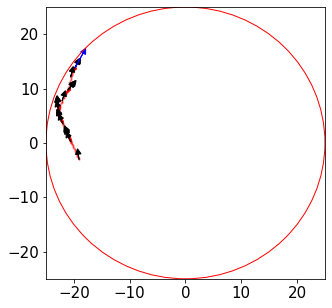

In [542]:
df=pd.DataFrame(np.vstack((x,y,body_angle)).T, 
columns=['x','y','angle'])
id = np.random.randint(df.shape[0])
fig = display_trajectory(df,index = id,past_memory=3*700)

# Subsample

In [543]:
N_Sub = 1
x_sub = x[::N_Sub]
y_sub = y[::N_Sub]
body_angle_sub = body_angle[::N_Sub]
fps = int(700/N_Sub)
print(fps)

700


In [544]:
from utils.utils import robust_diff
from preprocessing.smoothing import one_euro_filter

# Compute Lateral and Axial speed:


### Setup 1 euro filter parameters

The two parameters (fcmin and beta) can be set using a simple two-step procedure:
* First beta is set to 0 and fcmin (mincutoff) to a reasonable middle-ground value such as 1 Hz. Then the body part is held steady or moved at a very low speed while fcmin is adjusted to remove jitter and preserve an acceptable lag during these slow movements (decreasing fcmin reduces jitter but increases lag, fcmin must be > 0). 
* Next, the body part is moved quickly in different directions while beta is increased with a focus on minimizing lag. First find the right order of magnitude to tune beta, which depends on the kind of data you manipulate and their units: do not hesitate to start with values like 0.001 or 0.0001. You can first multiply and divide beta by factor 10 until you notice an effect on latency when moving quickly. 

Note that parameters fcmin and beta have clear conceptual relationships: if high speed lag is a problem, increase beta; if slow speed jitter is a problem, decrease fcmin.

In [545]:
# Define sample for tuning model:
IdSt = np.random.randint(x_sub.shape[0])
Duration = 10*fps
x_,y_,angle_ = x_sub[IdSt:IdSt+Duration],y_sub[IdSt:IdSt+Duration],body_angle_sub[IdSt:IdSt+Duration]


In [546]:
fc_min,beta = 20,1
x_clean = one_euro_filter(x_,fc_min,beta,fps)
y_clean = one_euro_filter(y_,fc_min,beta,fps)
angle_clean = one_euro_filter(angle_,fc_min,beta,fps)

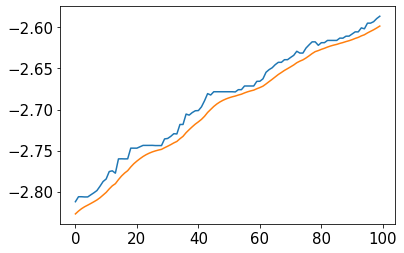

In [547]:
IdSt,Duration = 0,len(x_)
IdSt = 2300
Duration = 100
plt.plot(x_[IdSt:IdSt+Duration])
plt.plot(x_clean[IdSt:IdSt+Duration])

In [844]:
# Clean full data using set parameters:

fc_min,beta = 20,1
x_sub = one_euro_filter(x_sub,fc_min,beta,fps)
y_sub = one_euro_filter(y_sub,fc_min,beta,fps)
body_angle_sub = one_euro_filter(body_angle_sub,fc_min,beta,fps)


In [549]:
def compute_speed(x,y,body_angle,fps,Ndiff=45):
    body_vector = np.array([np.cos(body_angle),np.sin(body_angle)])[:,:-1]
    position_change = np.zeros_like(body_vector)
    position_change[0,:] = robust_diff(x,dt=1/fps, filter_length=Ndiff)[:-1]
    position_change[1,:] = robust_diff(y,dt=1/fps, filter_length=Ndiff)[:-1]
    angle = np.pi/2
    rotMat = np.array([[np.cos(angle),-np.sin(angle)],[np.sin(angle),np.cos(angle)]])
    body_vector_orth = np.dot(rotMat,body_vector)

    axial_speed = np.einsum('ij,ij->j',body_vector,position_change)
    lateral_speed = np.einsum('ij,ij->j',body_vector_orth,position_change)
    yaw_speed = robust_diff(np.unwrap(body_angle),dt=1/fps, filter_length=Ndiff)[:-1]
    axial_speed=np.concatenate((np.array([np.nan]),axial_speed))
    lateral_speed=np.concatenate((np.array([np.nan]),lateral_speed))
    yaw_speed=np.concatenate((np.array([np.nan]),yaw_speed))
    speed_amplitude = np.sqrt(np.power(axial_speed,2)+np.power(lateral_speed,2))
    
    return axial_speed,lateral_speed,yaw_speed

In [550]:
axial_speed,lateral_speed,yaw_speed = compute_speed(x_sub,y_sub,body_angle_sub,fps,Ndiff=45)

In [551]:
print(axial_speed.shape)
print(lateral_speed.shape)
print(yaw_speed.shape)

(8908250,)
(8908250,)
(8908250,)


In [552]:
traj_speed = np.vstack((axial_speed,lateral_speed,yaw_speed)).T
traj = np.vstack((x_sub,y_sub,body_angle_sub)).T

print(traj_speed.shape)
print(traj.shape)

(8908250, 3)
(8908250, 3)


### Compute difference over bout size windows:

##### Compute cumulative displacement:

In [713]:
# Replace nan with 0 in yawspeed:
traj_speed[np.isnan(traj_speed)]=0

In [716]:
traj_cumul = np.cumsum(np.abs(traj_speed),axis=0)

In [737]:
from scipy.ndimage.interpolation import shift

LAG = 140
dt = 1000/700*140
displacement = np.zeros_like(traj)
for i in range(3):
    tmp= np.copy(traj_cumul[:,i])
    tmp_future_lag=shift(tmp,-140, cval=0)
    displacement[:,i]=(tmp_future_lag-tmp)/dt

displacement[:140,:] = 0
displacement[-140:,:] = 0

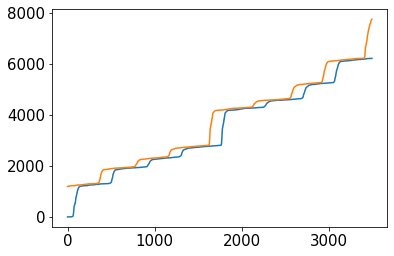

In [738]:
plt.plot(tmp[:700*5])
plt.plot(tmp_future_lag[:700*5])

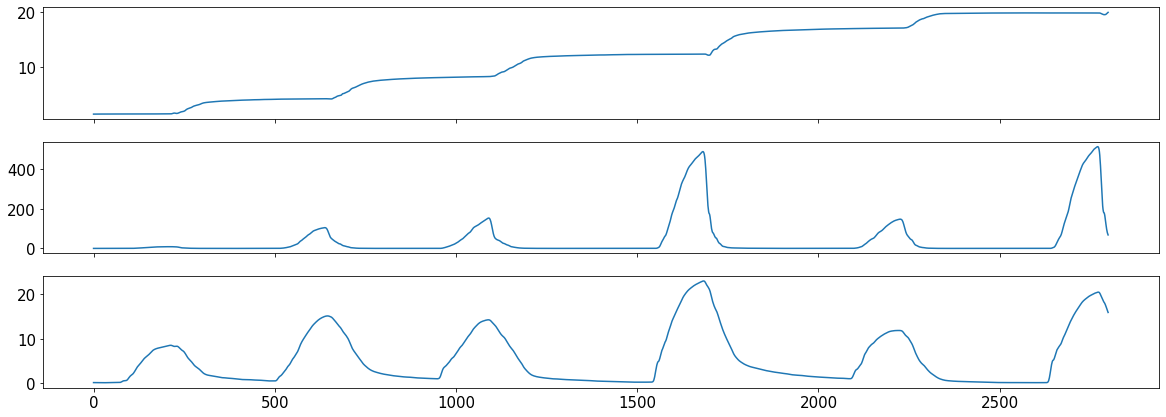

In [739]:
IdSt = np.random.randint(tmp.shape[0])
Duration = 700*4
fig, ax = plt.subplots(3,figsize=(20,7),sharex=True)
ax[0].plot(traj[IdSt:IdSt+Duration,0])
ax[1].plot(np.prod(displacement[IdSt:IdSt+Duration,:],axis=1))
ax[2].plot(np.linalg.norm(displacement[IdSt:IdSt+Duration,:],axis=1))
plt.show()



(0.0, 10000.0)

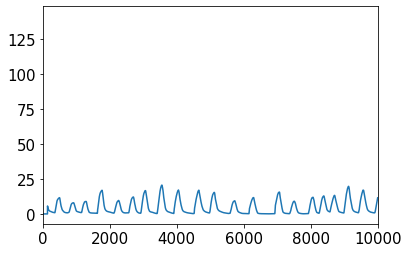

In [756]:
mobility = np.linalg.norm(displacement,axis=1)
plt.plot(mobility)
plt.xlim(0,10000)


In [757]:
log_x = np.log(x[x>0])

(2.7767227342643825, <AxesSubplot:>)


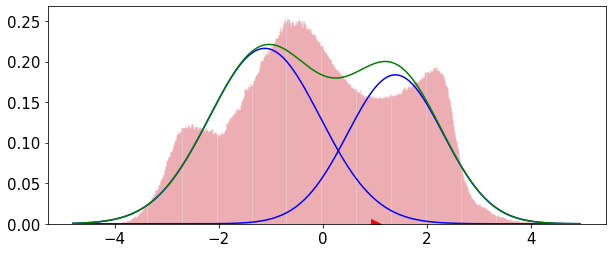

In [759]:
fig,ax = plt.subplots(1,figsize=(10,4))
thresh_peak = estimate_threshold_using_GMM(mobility,margin_std=2,axis=ax)
print(thresh_peak)

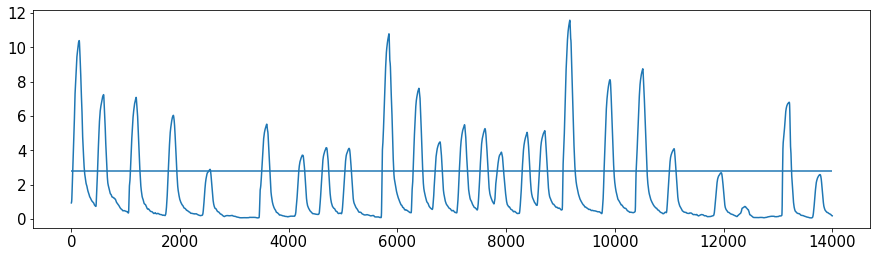

In [761]:
Duration = fps*20
IdSt = np.random.randint(len(yaw_speed))
plt.figure(figsize=(15,4))
plt.plot(x[IdSt:IdSt+Duration])
plt.hlines(2.8,0,Duration)
#plt.ylim(-60,60)

In [762]:
'''
Dict = np.load('./super_resolution/3atomsYawSpeedDictionnaryTu.npy')
N_atoms = Dict.shape[2]
# First Option full mutual inhibition:
Wg = np.ones((1,N_atoms))

plt.plot(Dict[:,0,:],'k')
plt.vlines(15,-0.4,0.4,'r')
print(Dict.shape)
Dict = Dict[::N_Sub,:,:]
print(Dict.shape)


from sparse_coding.sparse_coding import batch_tail_angle
from sporco import util
from sporco.admm import cbpdnin
# Batch Dataset:
yaw_speed_batch = batch_tail_angle(yaw_speed[:,np.newaxis])

print(yaw_speed_batch.shape)

T_trial = yaw_speed_batch.shape[0]
N_Seg = yaw_speed_batch.shape[1]
z = np.zeros((T_trial,N_atoms,1))

opt = cbpdnin.ConvBPDNInhib.Options({'Verbose': True, 'MaxMainIter': 200,
                                        'RelStopTol': 5e-3, 'AuxVarObj': False,'HighMemSolve': True})                                    
b = cbpdnin.ConvBPDNInhib(Dict[:,:,:],yaw_speed_batch,lmbda =0.1, Wg=Wg,gamma=0.1,mu=0.1,Whn=60,win_args='box', opt=opt, dimK=1, dimN=1)
z = b.solve().squeeze()
yaw_speed_hat = b.reconstruct().squeeze()

# Unbatch Result
z_flat = np.zeros((z.shape[0]*z.shape[1],z.shape[2]))
for i in range(z.shape[2]):
    z_flat[:,i] = z[:,:,i].T.flatten()
z = np.copy(z_flat)
z = z[:yaw_speed.shape[0],:]

yaw_speed_hat_ = yaw_speed_hat.T.flatten()
yaw_speed_hat_ = yaw_speed_hat_[:yaw_speed.shape[0]]

Duration = fps*10
IdSt = np.random.randint(len(yaw_speed))
fig, ax = plt.subplots(3,figsize=(20,7),sharex=True)
ax[0].plot(yaw_speed[IdSt:IdSt+Duration])
ax[0].plot(yaw_speed_hat_[IdSt:IdSt+Duration])
#ax[0].set_ylim(-60,60)
ax[1].plot(z[IdSt:IdSt+Duration])
ax[2].plot((np.max(np.abs(z),axis=1)>10)[IdSt:IdSt+Duration])
plt.show()'''

"\nDict = np.load('./super_resolution/3atomsYawSpeedDictionnaryTu.npy')\nN_atoms = Dict.shape[2]\n# First Option full mutual inhibition:\nWg = np.ones((1,N_atoms))\n\nplt.plot(Dict[:,0,:],'k')\nplt.vlines(15,-0.4,0.4,'r')\nprint(Dict.shape)\nDict = Dict[::N_Sub,:,:]\nprint(Dict.shape)\n\n\nfrom sparse_coding.sparse_coding import batch_tail_angle\nfrom sporco import util\nfrom sporco.admm import cbpdnin\n# Batch Dataset:\nyaw_speed_batch = batch_tail_angle(yaw_speed[:,np.newaxis])\n\nprint(yaw_speed_batch.shape)\n\nT_trial = yaw_speed_batch.shape[0]\nN_Seg = yaw_speed_batch.shape[1]\nz = np.zeros((T_trial,N_atoms,1))\n\nopt = cbpdnin.ConvBPDNInhib.Options({'Verbose': True, 'MaxMainIter': 200,\n                                        'RelStopTol': 5e-3, 'AuxVarObj': False,'HighMemSolve': True})                                    \nb = cbpdnin.ConvBPDNInhib(Dict[:,:,:],yaw_speed_batch,lmbda =0.1, Wg=Wg,gamma=0.1,mu=0.1,Whn=60,win_args='box', opt=opt, dimK=1, dimN=1)\nz = b.solve().squeeze

In [763]:
from scipy.signal import find_peaks
#for i in range(z.shape[1]):
#    z_normalized[:,i] = z[:,i]/np.std(z[:,i])
Duration = int(140/N_Sub)

#z_max = np.max(np.abs(z_normalized),axis=1)
#peaks, _ = find_peaks(z_max, height=8,distance=Duration)
peaks, _ = find_peaks(mobility, height=3,distance=Duration)

peaks_bin = np.zeros(z.shape[0])
peaks_bin[peaks]=1

## For each peak find next peak or gap in peaks...
Bout_Duration = Duration
kernel = np.ones(Bout_Duration)
filtered_forward = np.convolve(kernel,peaks_bin, mode='full')[:peaks_bin.shape[0]]
is_tail_active = 1.0*(filtered_forward>0)#*(filtered_backward>0)

In [764]:
from classification.template_bouts import generate_template_bouts

In [830]:
templates_flat,templates_labels,NameCat,Duration_after_Downsampling = generate_template_bouts(format='traj',template_duration =140,target_fps=700,ExludeCaptureSwim=True,delays=np.arange(0,50,3))

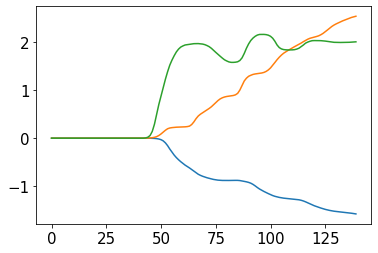

In [835]:
i = np.random.randint(templates_flat.shape[0])
plt.plot(templates_flat[i,:140])
plt.plot(templates_flat[i,140:140*2])
plt.plot(templates_flat[i,140*2:])
plt.show()

### Histogram of sparse code activation:

In [651]:
from segmentation.threshold import estimate_threshold_using_GMM
from scipy import stats

### Extract x,y,theta from each bout

In [787]:
from segmentation.align import align_bout_peaks

In [789]:
'''bouts_array = np.zeros((len(peaks),Duration,3))

onset = []
offset = []
aligned_peaks = []
Margin_before_peak = 0
i = 0
for iter_,peak in enumerate(peaks):
        if ((peak>Margin_before_peak)&(peak+140<z.shape[0])):
            id_st = peak - Margin_before_peak
            id_ed = id_st +Duration
            tmp = traj_speed[id_st:id_ed,2]
            try:
                peak_location = align_bout_peaks(tmp,quantile_threshold = 0.25 , minimum_peak_size = 0.25, minimum_peak_to_peak_amplitude = 4,debug_plot_axes=None)
            except:
                peak_location = np.nan
                
            if np.isnan(peak_location):
                peak_location = peak
            else:
                aligned_peaks.append(id_st+peak_location)
                id_st = id_st+peak_location-Margin_before_peak+3
                id_ed = id_st +Duration
                
            bouts_array[i,:,:] = traj[id_st:id_ed,:]
            i = i+1
            onset.append(id_st)
            offset.append(id_ed)
            
bouts_array = bouts_array[:i,:,:]'''

'bouts_array = np.zeros((len(peaks),Duration,3))\n\nonset = []\noffset = []\naligned_peaks = []\nMargin_before_peak = 0\ni = 0\nfor iter_,peak in enumerate(peaks):\n        if ((peak>Margin_before_peak)&(peak+140<z.shape[0])):\n            id_st = peak - Margin_before_peak\n            id_ed = id_st +Duration\n            tmp = traj_speed[id_st:id_ed,2]\n            try:\n                peak_location = align_bout_peaks(tmp,quantile_threshold = 0.25 , minimum_peak_size = 0.25, minimum_peak_to_peak_amplitude = 4,debug_plot_axes=None)\n            except:\n                peak_location = np.nan\n                \n            if np.isnan(peak_location):\n                peak_location = peak\n            else:\n                aligned_peaks.append(id_st+peak_location)\n                id_st = id_st+peak_location-Margin_before_peak+3\n                id_ed = id_st +Duration\n                \n            bouts_array[i,:,:] = traj[id_st:id_ed,:]\n            i = i+1\n            onset.append

In [790]:
bouts_array = np.zeros((len(peaks),Duration,3))

onset = []
offset = []
Margin_before_peak = 20
i = 0
for iter_,peak in enumerate(peaks):
        if ((peak>Margin_before_peak)&(peak+140<z.shape[0])):
            id_st = peak - Margin_before_peak
            id_ed = id_st +Duration
            bouts_array[i,:,:] = traj[id_st:id_ed,:]
            i = i+1
            onset.append(id_st)
            offset.append(id_ed)
            
bouts_array = bouts_array[:i,:,:]

### Rotate center every trajectory

In [791]:
bouts_array_flat = np.zeros((bouts_array.shape[0],140*3))
for i in range(bouts_array.shape[0]):
    sub_x,sub_y,sub_body_angle = bouts_array[i,:,0],bouts_array[i,:,1],bouts_array[i,:,2]
    Pos = np.zeros((2,140))
    Pos[0,:] = sub_x-sub_x[0]
    Pos[1,:] = sub_y-sub_y[0]
    theta=-sub_body_angle[0]
    body_angle_rotated=sub_body_angle-sub_body_angle[0]
    RotMat=np.array([[np.cos(theta),-np.sin(theta)],[np.sin(theta),np.cos(theta)]])
    PosRot=np.dot(RotMat,Pos)
    sub_x,sub_y,sub_body_angle = PosRot[0,:],PosRot[1,:],body_angle_rotated
    bouts_array_flat[i,:140] = sub_x
    bouts_array_flat[i,140:140*2] = sub_y
    bouts_array_flat[i,140*2:] = sub_body_angle


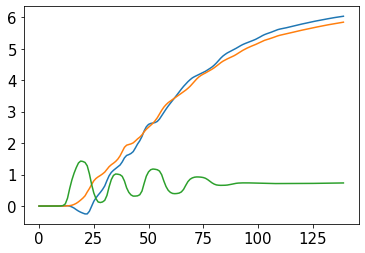

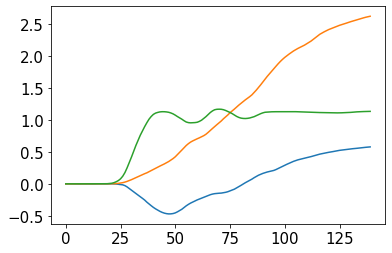

In [812]:
i = np.random.randint(templates_flat.shape[0])
plt.plot(templates_flat[i,:140])
plt.plot(templates_flat[i,140:140*2])
plt.plot(templates_flat[i,140*2:])
plt.show()

i = np.random.randint(bouts_array_flat.shape[0])
plt.plot(bouts_array_flat[i,:140])
plt.plot(bouts_array_flat[i,140:140*2])
plt.plot(bouts_array_flat[i,140*2:])
plt.show()

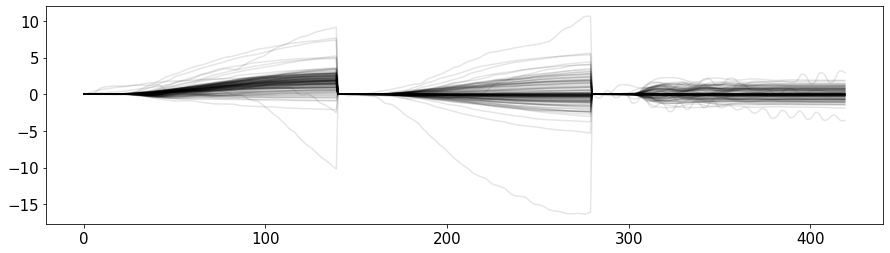

In [813]:
plt.figure(figsize=(15,4))
plt.plot(bouts_array_flat[::100,:].T,'k',alpha=0.1)
plt.show()

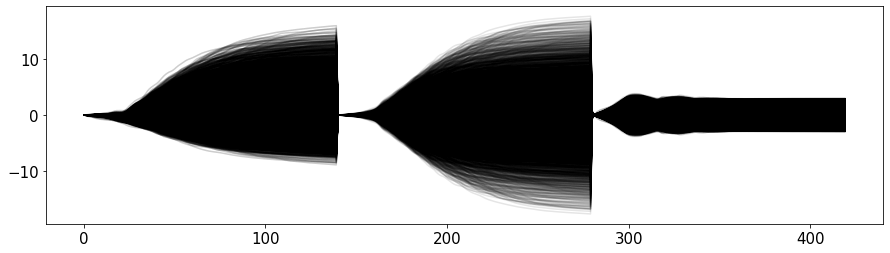

In [814]:
plt.figure(figsize=(15,4))
plt.plot(templates_flat.T,'k',alpha=0.1)
plt.show()

In [795]:
from classification.classify import create_classifier

In [796]:
classifier = create_classifier(templates_flat,templates_labels,n_neighbors=5)

In [572]:
bout_cat = classifier(bouts_array_flat)

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

## Normalizer:

In [836]:
# Scale Template and bouts:

scale_x,scale_y,scale_theta = 1/np.std(templates_flat[:,:140]),1/np.std(templates_flat[:,140:140*2]),1/np.std(templates_flat[:,140*2:])

print(scale_x,scale_y,scale_theta)

templates_flat_normalized = np.copy(templates_flat)
templates_flat_normalized[:,:140] = templates_flat_normalized[:,:140]*scale_x
templates_flat_normalized[:,140:140*2] = templates_flat_normalized[:,140:140*2]*scale_y
templates_flat_normalized[:,140*2:] = templates_flat_normalized[:,140*2:]*scale_theta


bouts_array_flat_normalized = np.copy(bouts_array_flat)
bouts_array_flat_normalized[:,:140] = bouts_array_flat_normalized[:,:140]*scale_x
bouts_array_flat_normalized[:,140:140*2] = bouts_array_flat_normalized[:,140:140*2]*scale_y
bouts_array_flat_normalized[:,140*2:] = bouts_array_flat_normalized[:,140*2:]*scale_theta

print(bouts_array_flat_normalized.shape)

0.5997891780209209 0.5086180823364761 1.0796659304998986
(13264, 420)


In [837]:

Duration = 700*7
IdSt = np.random.randint(z.shape[0])
IdEd = IdSt + Duration
t = np.linspace(0,Duration/700,Duration)
sub_onset,sub_offset,sub_i= [],[],[]

for i,(on_,off_) in enumerate(zip(onset,offset)):
    if (on_>IdSt)&(off_<IdEd):
        sub_onset.append(on_)
        sub_offset.append(off_)
        sub_i.append(i)

sub_peaks = np.where(peaks_bin[IdSt:IdEd]==1)[0]
sub_i = np.array(sub_i)

In [838]:
bouts_array_flat.shape

(13264, 420)

In [839]:
## For each bous in interval find nearest neighbor

from sklearn.neighbors import KNeighborsClassifier

print(bouts_array.shape,len(onset))

sub_bouts_array_flat = bouts_array_flat_normalized[sub_i,:]
print(sub_bouts_array_flat.shape)

# FLATTEN ARRAY:
#sub_bouts_array = sub_bouts_array[:,:,:]
#sub_bouts_array_flat = np.reshape(np.swapaxes(sub_bouts_array, 1, 2),(sub_bouts_array.shape[0],sub_bouts_array.shape[1]*sub_bouts_array.shape[2]))

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(templates_flat_normalized, templates_labels)
res = knn.kneighbors(sub_bouts_array_flat)
Nearest_bouts_x = templates_flat_normalized[res[1][:,0],:140]
Nearest_bouts_y = templates_flat_normalized[res[1][:,0],140:140*2]
Nearest_bouts_angle = templates_flat_normalized[res[1][:,0],140*2:]


(13264, 140, 3) 13264
(8, 420)


In [840]:
from matplotlib.patches import Rectangle

(0.0, 7.0)

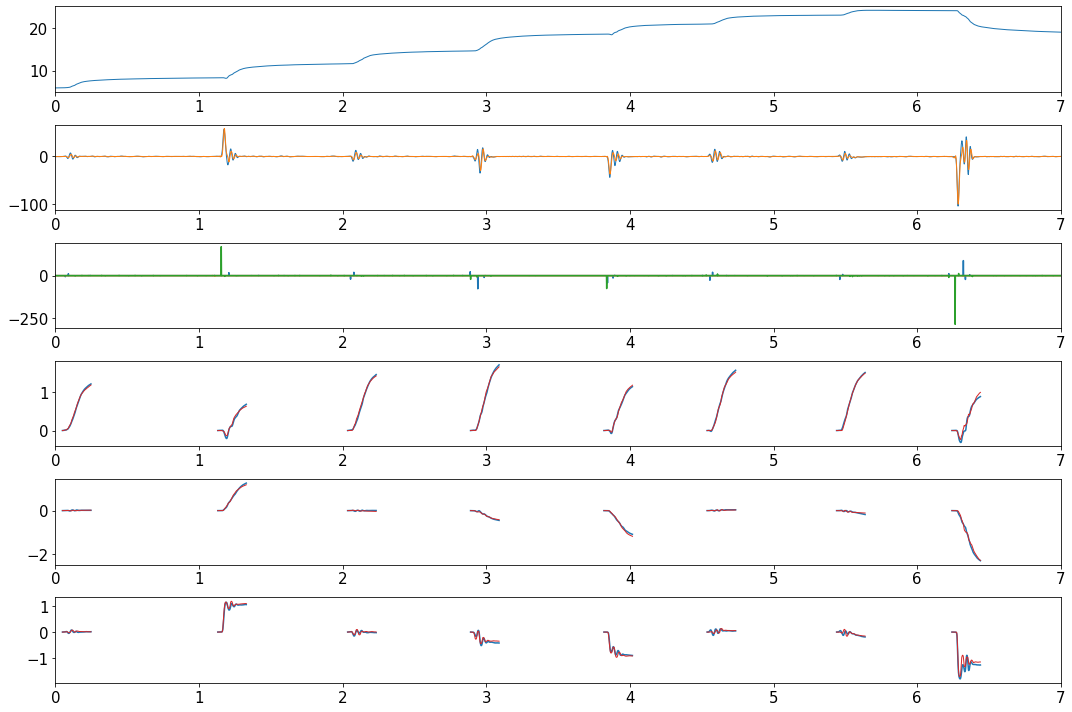

In [841]:

fig, ax = plt.subplots(facecolor='white',figsize=(15,10),tight_layout=True,sharex=True)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('axes', labelsize=15)

G = gridspec.GridSpec(6,1)

ax = plt.subplot(G[0])
#ax.plot(t,tail_angle[IdSt:IdEd,7],'k',lw=1)
ax.plot(t,traj[IdSt:IdEd,0],lw=1)
ax.set_xlim(0,Duration/700)

ax = plt.subplot(G[1])
#ax.plot(t,tail_angle[IdSt:IdEd,7],'k',lw=1)
ax.plot(t,yaw_speed[IdSt:IdEd],lw=1)
ax.plot(t,yaw_speed_hat_[IdSt:IdEd],lw=1)
ax.set_xlim(0,Duration/700)

ax = plt.subplot(G[2])
ax.plot(t,z[IdSt:IdEd,:])
#y =-(1-2*(np.max((z[IdSt:IdEd]),axis=1)>np.max(-(z[IdSt:IdEd]),axis=1)))*np.max(np.abs(z[IdSt:IdEd]),axis=1)*peaks_bin[IdSt:IdEd]
#ax.scatter(t[sub_peaks],y[sub_peaks],color = 'r')
#for p in sub_peaks:
#    ax.add_patch(Rectangle((t[p],-10),140/700,20,facecolor="red",alpha=0.3))
ax.set_xlim(0,Duration/700)


ax = plt.subplot(G[3])
for i,(on_,off_) in enumerate(zip(sub_onset,sub_offset)):
    ax.plot((np.arange(on_,off_)-IdSt)/700,sub_bouts_array_flat[i,:140],'tab:blue')
    off_ = on_+140
    ax.plot((np.arange(on_,off_)-IdSt)/700,Nearest_bouts_x[i,:],'tab:red',lw=1)
ax.set_xlim(0,Duration/700)

ax = plt.subplot(G[4])
for i,(on_,off_) in enumerate(zip(sub_onset,sub_offset)):
    ax.plot((np.arange(on_,off_)-IdSt)/700,sub_bouts_array_flat[i,140:140*2],'tab:blue')
    off_ = on_+140
    ax.plot((np.arange(on_,off_)-IdSt)/700,Nearest_bouts_y[i,:],'tab:red',lw=1)
ax.set_xlim(0,Duration/700)


ax = plt.subplot(G[5])
for i,(on_,off_) in enumerate(zip(sub_onset,sub_offset)):
    ax.plot((np.arange(on_,off_)-IdSt)/700,sub_bouts_array_flat[i,140*2:],'tab:blue')
    off_ = on_+140
    ax.plot((np.arange(on_,off_)-IdSt)/700,Nearest_bouts_angle[i,:],'tab:red',lw=1)
ax.set_xlim(0,Duration/700)

### Display Template traj:

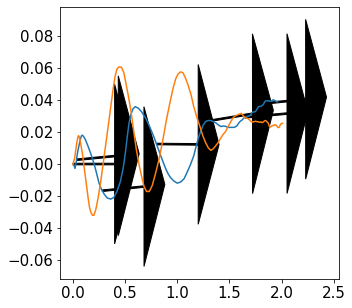

In [843]:
k = 0
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot()
ax.plot(Nearest_bouts_x[k,:]/scale_x,Nearest_bouts_y[k,:]/scale_y)
for i in range(0,140,20):
    c = .4*np.cos(Nearest_bouts_angle[k,i]/scale_theta)
    s = .2*np.sin(Nearest_bouts_angle[k,i]/scale_theta)
    x_end = Nearest_bouts_x[k,i]/scale_x
    y_end = Nearest_bouts_y[k,i]/scale_y
    ax.arrow(x_end,y_end,c,s, head_width=.1, head_length=.2, fc='k', ec='k')

ax.plot(sub_bouts_array_flat[k,:140]/scale_x,sub_bouts_array_flat[k,140:140*2]/scale_y)